In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install transformers accelerate


In [17]:
%pip install diffusers
%pip install peft

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import login
from peft import LoraConfig
import torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from datasets import load_dataset
from functools import partial
from PIL import Image
from kaggle_secrets import UserSecretsClient
from torch.utils.data import Dataset
import pandas as pd
from pydantic import BaseModel
from diffusers.training_utils import compute_snr

In [20]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

In [21]:
class RecycledMaterialsDataset(Dataset):
    def __init__(self, image_dir: Path, captions_file: Path, tokenizer: CLIPTokenizer):
        # Load and parse the text file
        with open(captions_file, "r") as f:
            lines = f.readlines()
        
        # Parse image paths and descriptions into a list of tuples
        self.data = [
            (line.strip().split(":")[0], line.strip().split(":")[1].strip()) 
            for line in lines
        ]
        self.image_dir = image_dir
        self.tokenizer = tokenizer

        # Transform pipeline to resize images to 512x512 and normalize them
        self.train_transforms = transforms.Compose([
            transforms.Resize((512, 512)),  # Resize images to 512x512
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize for Stable Diffusion
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, description = self.data[idx]

        # Load and transform the image
        image_path = self.image_dir / image_name
        image = Image.open(image_path).convert("RGB")
        image = self.train_transforms(image)

        # Tokenize the description
        input_ids = self.tokenizer(
            description,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}


In [22]:
class TrainingConfig(BaseModel):
    # Training settings
    train_steps: int = 500  
    lr: float = 1e-5
    batch_size: int = 2  
    accumulation_steps: int = 2
    rank: int = 64  
    max_grad_norm: float = 1.0  
    pretrained_name: str = "stabilityai/stable-diffusion-2-1"

    # **Update these with the correct paths on Kaggle**
    image_dir: str = "/kaggle/input/modification/Target"
    captions_file: str = "/kaggle/input/textfinal/final_randomized_diy_tin_can_captions.txt"

    snr_gamma: float = -1  
    seed: int = 42  


In [23]:
class RecycledMaterialsDataset(Dataset):
    def __init__(self, config: TrainingConfig, tokenizer: CLIPTokenizer):
        # Read the text file containing image names and descriptions
        with open(config.captions_file, "r") as f:
            lines = f.readlines()

        # Parse each line into (image_name, description)
        self.data = [
            (line.strip().split(":")[0], line.strip().split(":")[1].strip()) 
            for line in lines
        ]
        
        self.image_dir = Path(config.image_dir)  # The path to the images
        self.tokenizer = tokenizer  # Tokenizer for the descriptions

        # Transformation: resize images to 512x512 and normalize
        self.train_transforms = transforms.Compose([
            transforms.Resize((512, 512)),  # Resize to 512x512
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize for Stable Diffusion
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image name and description
        image_name, description = self.data[idx]

        # Load and transform the image
        image_path = self.image_dir / image_name
        image = Image.open(image_path).convert("RGB")
        image = self.train_transforms(image)

        # Tokenize the caption
        input_ids = self.tokenizer(
            description,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}


In [24]:
def setup_models_for_training(model_name, rank: int=64):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze all weights
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # config LoRA
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # set trainaible weights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]

In [9]:
# Importing necessary modules
from pathlib import Path

# Initialize the training configuration
config = TrainingConfig()

# Load the tokenizer
tokenizer = CLIPTokenizer.from_pretrained(config.pretrained_name, subfolder="tokenizer")

# Create the dataset object
dataset = RecycledMaterialsDataset(config, tokenizer)

# Print an example to confirm it’s working
print(dataset[0])


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

{'pixel_values': tensor([[[ 0.3333,  0.3647,  0.3961,  ...,  0.6706,  0.6706,  0.6706],
         [ 0.3490,  0.3569,  0.3412,  ...,  0.6549,  0.6549,  0.6549],
         [ 0.3647,  0.3961,  0.3882,  ...,  0.6863,  0.6863,  0.6941],
         ...,
         [ 0.3255,  0.3255,  0.3569,  ...,  0.2471,  0.2549,  0.2549],
         [ 0.3176,  0.3333,  0.3490,  ...,  0.4510,  0.4431,  0.4275],
         [ 0.3333,  0.3569,  0.3333,  ...,  0.3647,  0.3490,  0.3098]],

        [[ 0.3412,  0.3647,  0.3961,  ...,  0.6706,  0.6706,  0.6706],
         [ 0.3569,  0.3647,  0.3412,  ...,  0.6549,  0.6549,  0.6549],
         [ 0.3725,  0.3961,  0.3882,  ...,  0.6863,  0.6863,  0.6863],
         ...,
         [ 0.0510,  0.0510,  0.0824,  ..., -0.0275, -0.0196, -0.0196],
         [ 0.0431,  0.0588,  0.0745,  ...,  0.1765,  0.1686,  0.1529],
         [ 0.0588,  0.0824,  0.0588,  ...,  0.0902,  0.0745,  0.0353]],

        [[ 0.3020,  0.3412,  0.3804,  ...,  0.6706,  0.6706,  0.6706],
         [ 0.3176,  0.3412, 

In [25]:
def train(
    tokenizer: CLIPTokenizer, 
    text_encoder: CLIPTextModel, 
    vae: AutoencoderKL, 
    scheduler: DDPMScheduler, 
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    lora_params = get_lora_params(unet)

    # Set models to evaluation or training mode
    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # Load the dataset using your custom dataset class
    train_dataset = RecycledMaterialsDataset(config, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # Optimizer and training steps calculation
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    # Adjust the learning rate based on batch size and accumulation steps
    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)
    scaler = torch.cuda.amp.GradScaler()

    # Progress bar setup
    global_step = 0
    progress_bar = tqdm(range(config.train_steps), desc="Steps")

    # Display config details
    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []

    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            # Use mixed precision
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    # Get the hidden states from the text encoder
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                # Generate random noise for the diffusion process
                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                # Encode the images into latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                # Add noise to the latents
                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                
                # Predict noise using the UNet
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                # Compute loss (weighted MSE or standard MSE)
                if config.snr_gamma > 0:
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            # Accumulate gradients
            global_step += 1
            scaler.scale(loss).backward()

            # Apply gradient updates
            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())
            progress_bar.set_postfix({"loss": losses[-1]})

            # Stop training if the target number of steps is reached
            if global_step / config.accumulation_steps >= config.train_steps:
                break
    
    return {"losses": losses}


In [26]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 64
config.train_steps = 500
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

<ipython-input-25-63d584e5f7dc>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/500 [00:00<?, ?it/s]

configs: train_steps=500 lr=1e-05 batch_size=2 accumulation_steps=2 rank=64 max_grad_norm=1.0 pretrained_name='stabilityai/stable-diffusion-2-1' image_dir='/kaggle/input/modification/Target' captions_file='/kaggle/input/textfinal/final_randomized_diy_tin_can_captions.txt' snr_gamma=5.0 seed=42
epochs: 4
steps per epoch: 149
total steps: 500
accumulation steps: 2
total batch size: 4
lr: 4e-05


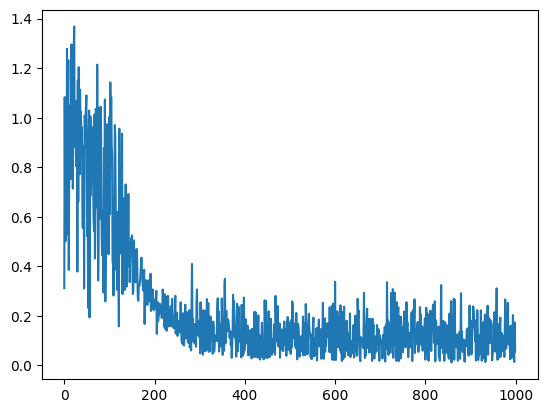

In [27]:
plt.plot(outputs["losses"])
plt.show()

In [28]:
unet = models[-1]  # Get the UNet from the models tuple

# Extract and convert the LoRA weights
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

# Save the LoRA weights directly as a PyTorch file in Kaggle's working directory
save_path = "/kaggle/working/lora_tin_can_weightsV2.1.pth"
torch.save(unet_lora_state_dict, save_path)

print(f"LoRA weights saved directly to: {save_path}")


LoRA weights saved directly to: /kaggle/working/lora_tin_can_weightsV2.1.pth


In [30]:
from diffusers import StableDiffusionPipeline
import torch

# Set device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the base model
pipeline = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

# Load the LoRA weights into the UNet
unet = pipeline.unet
lora_weights = torch.load("/kaggle/working/lora_tin_can_weightsV2.1.pth", weights_only=True)
unet.load_state_dict(lora_weights, strict=False)

print("LoRA weights loaded successfully.")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

LoRA weights loaded successfully.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated image saved to: /kaggle/working/generated_tin_can_image.png


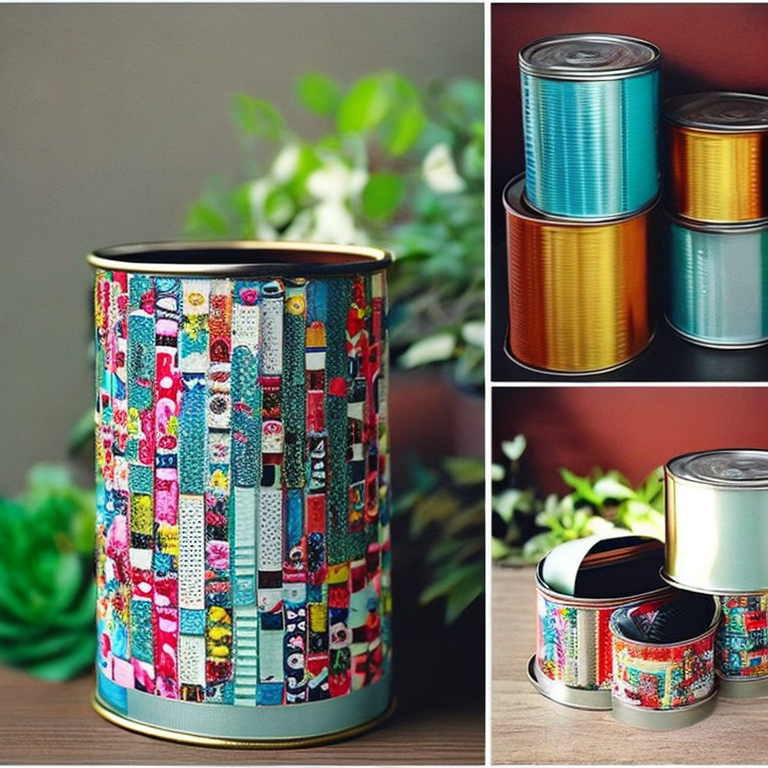

In [36]:
# Define a simplified prompt related to tin cans
prompt = " single creative Diy tin can for home decoration."

# Generate the image
with torch.autocast(device_type=device):
    image = pipeline(prompt).images[0]

# Save and display the generated image
image_path = "/kaggle/working/generated_tin_can_image.png"
image.save(image_path)
print(f"Generated image saved to: {image_path}")
image.save(image_path)

# Display the image in the notebook
from IPython.display import Image as IPImage, display
display(IPImage(image_path))
